In [1]:
import pandas as pd
import numpy as np

from astropy import units as u, constants as c

from scipy.optimize import fsolve

from matplotlib import pyplot as plt

# Ryden + Pogge Problem 3.2

In [2]:
# part b

def f(W):
    return (1/150) - (1-W)/100 - W/1e4

res = fsolve(f, 0.5)
res, 1-res

(array([0.33670034]), array([0.66329966]))

# Ryden + Pogge Problem 4.2

In [3]:
O3_Q0 = 10**(49.77) * u.s**-1
O3_Q1 = 10**(49.14) * u.s**-1

O6_Q0 = 10**(49.32) * u.s**-1
O6_Q1 = 10**(48.52) * u.s**-1

O9_Q0 = 10**(48.65) * u.s**-1
O9_Q1 = 10**(47.06) * u.s**-1

In [4]:
# part a

T = 1e4 * u.K
n = 1e3 * u.cm**-3

def alpha_B(T):
    to_ret = 3.1e-13 * u.cm**3 * u.s**-1 * (T/(8000*u.K))**-0.82
    return to_ret

def R_s(Q0, T=T, n_H=n):
    return 5.5*u.pc * (Q0 / (1e49*u.s**-1))**(1/3) * (alpha_B(T) / (3e-13*u.cm**3*u.s**-1))**(-1/3) * (n_H / (40*u.cm**-3))**(-2/3)

print("O3:", R_s(O3_Q0))
print("O6:", R_s(O6_Q0))
print("O9:", R_s(O9_Q0))

O3: 1.2212688337393727 pc
O6: 0.8645921224455196 pc
O9: 0.5169849981023891 pc


In [5]:
# part b

R_s(O3_Q0, n_H=0.3*u.cm**-3)

<Quantity 272.5191994 pc>

In [6]:
# part c

O3_Q1/O3_Q0, O6_Q1/O6_Q0, O9_Q1/O9_Q0

(<Quantity 0.23442288>, <Quantity 0.15848932>, <Quantity 0.02570396>)

# Ryden + Pogge Problem 4.3

In [7]:
from scipy.integrate import quad as integrator

def weins(T, hnu, L_typical=320_000*c.L_sun): # https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html

    hnu = hnu * u.eV
    T = T * u.K
    
    nu = hnu / c.h
    e = (hnu / (c.k_B * T)).decompose()
    # print(e)
    I_nu = 2*c.h*nu**3 / c.c**2 * np.exp(-e)

    # assume isotropic
    F_nu = np.pi*I_nu

    # get a rtpical radius
    r = np.sqrt(L_typical / (4*np.pi*c.sigma_sb*T**4))
    
    # convert to luminosity
    L_nu = 4*np.pi * r**2 * F_nu

    return L_nu.cgs.value

def Q(T, hnu0, hnu1=np.inf):

    integrand = lambda hnu : weins(T, hnu) / hnu

    return integrator(integrand, hnu0, hnu1)

T = 31_500 # K
T_ISM = 8_000 # K
nC_nH = 2e-4
alpha_C = 4.66e-13 * u.cm**3 * u.s**-1

hnu0_H = 13.6 #eV
hnu1_H = np.inf

hnu0_C = 11.18 #eV
hnu1_C = 13.6 #eV

In [8]:
# part (a)
QC_QH = Q(T, hnu0_C, hnu1_C)[0]/Q(T, hnu0_H, hnu1_H)[0]
QC_QH

0.7870164729813142

In [9]:
# part b

aB = alpha_B(T_ISM*u.K).cgs
print(aB)

RC_RH = QC_QH**(1/3) * (nC_nH)**(-2/3) * (aB / alpha_C)**(1/3)
RC_RH

3.1e-13 cm3 / s


<Quantity 235.66759481>

In [10]:
# part c
n_H = 1 * u.cm**-3
Q0 = 3.55e48*u.s**-1

R_H = R_s(Q0, T_ISM*u.K, n_H)
R_C = RC_RH * R_H
R_C

<Quantity 10617.73441156 pc>

In [11]:
# part d
RC_RH = 0.01**(-1/3) * QC_QH**(1/3) * (nC_nH)**(-1/3) * (aB / alpha_C)**(1/3)
print(RC_RH)

R_H = R_s(Q0, T_ISM*u.K, n_H)
R_C = RC_RH * R_H
R_C

63.97002710087932


<Quantity 2882.09653351 pc>

# Ryden + Pogge Problem 4.3

In [12]:
def alpha_B(T):
    to_ret = 3.1e-13 * u.cm**3 * u.s**-1 * (T/(8000))**-0.82
    return to_ret

def heating_rate(T_gas, T_star, n_H, **kwargs):
    aB = alpha_B(T_gas).cgs.value
    return n_H**2 * aB * c.k_B.cgs.value * T_star

def cooling_rate(T_gas, T_star, n_H, x=1):

    aB = alpha_B(T_gas).value
    
    # radiative recombination
    ell_rr = 0.68 * n_H**2 * aB * c.k_B.cgs.value * T_gas

    # free-free cooling
    ell_ff = 0.7 * ell_rr * (T_gas / 8000)**0.32

    # collisionall excited line emission
    ell_CII_H = 5.2e-27 * n_H**2 * (T_gas/100)**0.13 * np.exp(-91.2/T_gas)
    ell_CII_e = 3.1e-27 * n_H**2 * (x/1e-3) * (T_gas/100)**-0.5 * np.exp(-91.2/T_gas)
    ell_OI_H  = 4.1e-27 * n_H**2 * (T_gas/100)**0.42 * np.exp(-228/T_gas)
    ell_Lya_e = 6e-22 * n_H**2 * (x/1e-3) * (T_gas/1e4)**-0.5 * np.exp(-1.18e5/T_gas)

    # sum them together 
    return ell_rr + ell_ff + ell_Lya_e # + ell_CII_H + ell_CII_e + ell_OI_H

Text(0.5, 0, '$T_{gas}$')

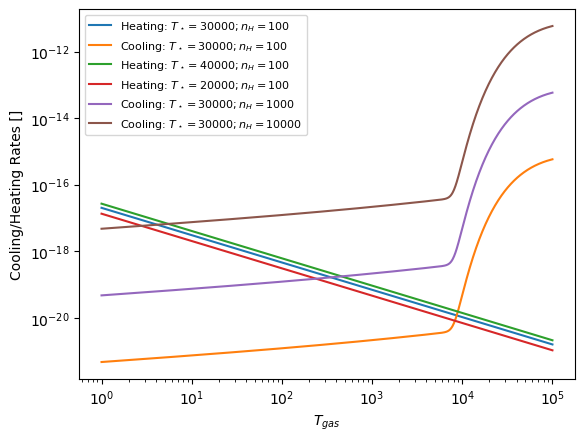

In [13]:
# part (3)

def lab(T_gas, T_star, n_H, type):
    return rf"{type}: $T_\star={T_star}; n_H={n_H}$"

fig, ax = plt.subplots()

T_gas = np.logspace(0, 5, 1000)

kwargs = dict(x=1)

args = (T_gas, 30_000, 100)
ax.plot(T_gas, heating_rate(*args, **kwargs), label=lab(*args, "Heating"))
ax.plot(T_gas, cooling_rate(*args, **kwargs), label=lab(*args, "Cooling"))

args = (T_gas, 40_000, 100)
ax.plot(T_gas, heating_rate(*args, **kwargs), label=lab(*args, "Heating"))

args = (T_gas, 20_000, 100)
ax.plot(T_gas, heating_rate(*args, **kwargs), label=lab(*args, "Heating"))

args = (T_gas, 30_000, 1_000)
ax.plot(T_gas, cooling_rate(*args, **kwargs), label=lab(*args, "Cooling"))

args = (T_gas, 30_000, 10_000)
ax.plot(T_gas, cooling_rate(*args, **kwargs), label=lab(*args, "Cooling"))


ax.set_yscale("log")
ax.set_xscale("log")

ax.legend(fontsize=8)

ax.set_ylabel("Cooling/Heating Rates []")
ax.set_xlabel(r"$T_{gas}$")

In [14]:
# part (d)

for T_star in [20_000, 30_000, 40_000]:
    kwargs = dict(
        T_star = T_star, 
        n_H = 100
    )
    f = lambda T_gas : heating_rate(T_gas, **kwargs) - cooling_rate(T_gas, **kwargs)

    res = fsolve(f, 1e4)

    print(f"T_star = {T_star}, T_eq = {res[0]:.2f}")

T_star = 20000, T_eq = 8286.93
T_star = 30000, T_eq = 8673.68
T_star = 40000, T_eq = 8927.73


In [15]:
# part (e)

for init_guess, n_H in zip([1e4, 1e2, 1e1], [100, 1_000, 10_000]):
    kwargs = dict(
        T_star = 30_000, 
        n_H = n_H
    )
    f = lambda T_gas : heating_rate(T_gas, **kwargs) - cooling_rate(T_gas, **kwargs)

    res = fsolve(f, init_guess)

    print(f"n_H = {n_H}, T_eq = {res[0]:.2f}")

n_H = 100, T_eq = 8673.68
n_H = 1000, T_eq = 8673.68
n_H = 10000, T_eq = 8673.68
